# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.


This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

C:\Users\Admin\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [4]:
from common_utils import MLP, CustomDataset, EarlyStopper, preprocess_dataset

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [7]:
no_features = 77
no_hidden = 128
no_labels = 1

no_folds = 5

In [9]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # create KFold object
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=42)

    # create dicts
    X_train_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    X_val_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    y_train_dict = {batch_size: [] for batch_size in batch_sizes}
    y_val_dict = {batch_size: [] for batch_size in batch_sizes}
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Scaling
        X_train_scaled, X_val_scaled = preprocess_dataset(X_train_fold, X_val_fold)
        
        for batch_size in batch_sizes:
            X_train_scaled_dict[batch_size].append(X_train_scaled)
            X_val_scaled_dict[batch_size].append(X_val_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()


# Remove 'filename' and 'label' columns from features
X_train = df.drop(['filename', 'label'], axis=1)
y_train = preprocessing.LabelEncoder().fit_transform(df['label'])

batch_sizes = [64, 128, 256, 512]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [13]:
from statistics import mean

In [15]:
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, parameters):
    cross_validation_accuracies = {}
    cross_validation_times = {}
    last_epoch_times = {}

    for batch_size in batch_sizes:
        fold_accuracies = []
        fold_times = []
        fold_last_epoch_times = []

        for fold in range(len(X_train_scaled_dict[batch_size])):
            start_time = time.time()

            # Dataset & Dataloader objects
            train_dataset = CustomDataset(X_train_scaled_dict[batch_size][fold], y_train_dict[batch_size][fold])
            test_dataset = CustomDataset(X_val_scaled_dict[batch_size][fold], y_val_dict[batch_size][fold])
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

            # Initialize model, loss function, and optimizer
            model = MLP(X_train.shape[1], 128, 1)
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            # Training loop
            n_epochs = 15
            for epoch in range(n_epochs):
                model.train()
                if epoch == n_epochs - 1:  # If it's the last epoch
                    last_epoch_start_time = time.time()  # Start timing the last epoch
                    
                for X_batch, y_batch in train_loader:
                    y_batch = y_batch.float().unsqueeze(1)
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if epoch == n_epochs - 1:  # If it's the last epoch
                    last_epoch_time = time.time() - last_epoch_start_time  # Calculate time for the last epoch
                    fold_last_epoch_times.append(last_epoch_time)  # Add to the list

            # Evaluation
            model.eval()
            with torch.no_grad():
                y_pred = model(test_dataset.X)
                accuracy = ((y_pred > 0.5).float() == test_dataset.y.unsqueeze(1).float()).float().mean().item()

            fold_accuracies.append(accuracy)
            fold_times.append(time.time() - start_time)

        print(fold_accuracies)
        print(fold_times)
        
        cross_validation_accuracies[batch_size] = mean(fold_accuracies)
        cross_validation_times[batch_size] = mean(fold_times)
        last_epoch_times[batch_size] = fold_last_epoch_times

    return cross_validation_accuracies, cross_validation_times, last_epoch_times


In [17]:
batch_sizes = [64, 128, 256, 512]
cross_validation_accuracies, cross_validation_times, last_epoch_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


[0.746268630027771, 0.7524875402450562, 0.7494815587997437, 0.7490667700767517, 0.7349647283554077]
[3.738298177719116, 3.740811347961426, 3.7538812160491943, 3.8152055740356445, 3.769463539123535]
[0.7446103096008301, 0.7508291602134705, 0.7320613861083984, 0.7445043325424194, 0.7482372522354126]
[2.8103840351104736, 2.8134000301361084, 2.804352283477783, 2.7741920948028564, 2.760620594024658]
[0.7330016493797302, 0.7251243591308594, 0.726669430732727, 0.7196184396743774, 0.7216922640800476]
[2.3228020668029785, 2.362009286880493, 2.2619800567626953, 2.3283307552337646, 2.3424062728881836]
[0.7180762887001038, 0.7160032987594604, 0.711323082447052, 0.7055163979530334, 0.7080049514770508]
[1.9091100692749023, 1.916651725769043, 2.014669179916382, 1.9040842056274414, 1.9282119274139404]


In [18]:
# Print results
mean_accuracies = []

for batch_size in batch_sizes:
    print(f"Batch size: {batch_size}")
    print(f"  Average accuracy: {cross_validation_accuracies[batch_size]:.4f}")
    mean_accuracies.append(cross_validation_accuracies[batch_size])
    print(f"  Average time: {cross_validation_times[batch_size]:.2f} seconds")

# Find best batch size
# best_batch_size = max(cross_validation_accuracies, key=cross_validation_accuracies.get)
# print(f"\nBest batch size: {best_batch_size}")
# print(f"Best average accuracy: {cross_validation_accuracies[best_batch_size]:.4f}")

Batch size: 64
  Average accuracy: 0.7465
  Average time: 3.76 seconds
Batch size: 128
  Average accuracy: 0.7440
  Average time: 2.79 seconds
Batch size: 256
  Average accuracy: 0.7252
  Average time: 2.32 seconds
Batch size: 512
  Average accuracy: 0.7118
  Average time: 1.93 seconds


4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

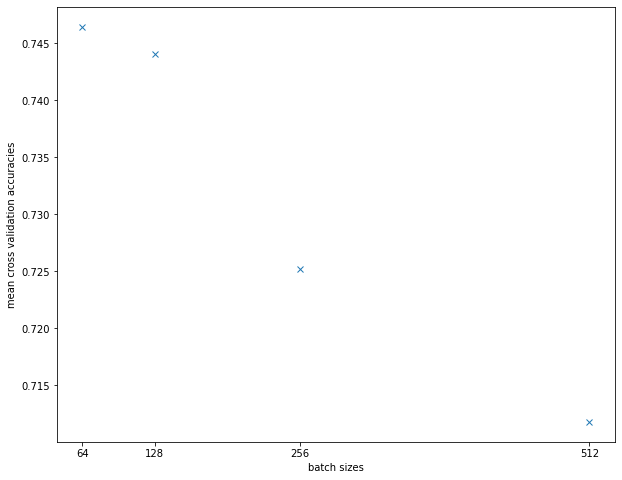

In [20]:
fig = plt.figure(figsize=(10,8))
plt.plot(batch_sizes, mean_accuracies, marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('batch sizes')
plt.ylabel('mean cross validation accuracies')
plt.show()


4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [22]:
# Create lists to hold the data for the DataFrame
batch_size_list = []
last_epoch_time_list = []
fold_list = [1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5]

# Populate the lists
for batch_size in batch_sizes:
    for time in last_epoch_times[batch_size]:
        batch_size_list.append(batch_size)
        last_epoch_time_list.append(time)

# Create the DataFrame
df = pd.DataFrame({
    'Batch Size': batch_size_list,
    'Fold number': fold_list,
    'Last Epoch Time': last_epoch_time_list
})

# Print DataFrame
df

,Batch Size,Fold number,Last Epoch Time
0,64,1,0.247309
1,64,2,0.245299
2,64,3,0.252337
3,64,4,0.249823
4,64,5,0.251331
5,128,1,0.186488
6,128,2,0.185482
7,128,3,0.183975
8,128,4,0.181963
9,128,5,0.183472


In [23]:
# Checking mean last epoch time against batch sizes
print(df.groupby('Batch Size')['Last Epoch Time'].describe())

            count      mean       std       min       25%       50%       75%  \
Batch Size                                                                      
64            5.0  0.249220  0.002896  0.245299  0.247309  0.249823  0.251331   
128           5.0  0.184276  0.001763  0.181963  0.183472  0.183975  0.185482   
256           5.0  0.148487  0.005604  0.141751  0.145270  0.147280  0.152307   
512           5.0  0.129385  0.016021  0.112093  0.125666  0.126671  0.126671   

                 max  
Batch Size            
64          0.252337  
128         0.186488  
256         0.155826  
512         0.155825  


In [26]:
# YOUR CODE HERE
optimal_batch_size = 64
reason = "Batch size of 64 has the highest cross-validation accuracy, even though it has the longest average last epoch training time."